# Feature space: non-ML

What kind of features are most predictive of mutational stability?

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import os
import sys
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.srv.sequence_exploration.sequence_analysis import b_tabulate_mutation_info
from src.utils.data.data_format_tools.common import load_json_as_dict
from src.utils.common.setup_new import prepare_config
from src.utils.circuit.agnostic_circuits.circuit_manager_new import CircuitModeller
from src.utils.evolution.evolver import Evolver
from src.utils.misc.type_handling import flatten_listlike
from src.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from tests_local.shared import create_test_inputs, CONFIG, TEST_CONFIG

# config = load_json_as_dict('../tests_local/configs/simple_circuit.json')
SEQ_LENGTH = 20


In [7]:
circuits, config, result_writer, info = create_test_inputs(deepcopy(CONFIG))

experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/binding_rates_dissociation/0_weak_binding_rates_dissociation.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/eqconstants/0_weak_eqconstants.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/energies/0_weak_energies.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/binding_sites/0_weak_binding_sites.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/binding_rates_dissociation/1_med_weak_binding_rates_dissociation.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead

Steady states:  100  iterations.  2  left to steady out.  0:01:24.760194
Done:  0:02:48.112060


circuit_manager_new.py:run_batch():635: 		Method init_circuits took 169.138842s WARNING
circuit_manager_new.py:run_batch():599: 		Running 100 Subcircuits - 0_weak: simulate_signal_batch WARNING


AttributeError: 'Circuit' object has no attribute 'include_prod_deg'

Get info

In [ ]:

info = b_tabulate_mutation_info(result_writer.ensemble_write_dir,
                                data_writer=result_writer, experiment_config=config)

In [ ]:
# circuits = [Evolver(data_writer=result_writer,
#                     sequence_type=config.get('system_type')).mutate(
#             c,
#             write_to_subsystem=True,
#             algorithm=config.get('mutations', {}).get('algorithm', 'random')) for c in circuits]
# circuit_modeller = CircuitModeller(result_writer=result_writer, config=config)
# circuits = circuit_modeller.batch_circuits(
#     circuits=circuits,
#     methods={
#         "compute_interactions": {},
#         "init_circuits": {'batch': True},
#         'simulate_signal_batch': {'ref_circuit': None,
#                                   'batch': config['simulation']['use_batch_mutations']},
#         'write_results': {'no_visualisations': False, # config['experiment']['no_visualisations'],
#                           'no_numerical': False} #config['experiment']['no_numerical']}
#     }
# )



In [ ]:
circuits[0].interactions.__dict__

{'binding_rates_association': array([[0.00150958, 0.00150958, 0.00150958],
        [0.00150958, 0.00150958, 0.00150958],
        [0.00150958, 0.00150958, 0.00150958]]),
 'binding_rates_dissociation': array([[0.00150958, 0.00150958, 0.00150958],
        [0.00150958, 0.00150958, 0.00150958],
        [0.00150958, 0.00150958, 0.00150958]]),
 'energies': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'eqconstants': array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]),
 'binding_sites': array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]),
 'units': 'unknown'}

In [ ]:

num_bs = int((100 / np.abs(-11.42)))

num_groups = np.random.randint(int(SEQ_LENGTH/num_bs)) + 1

starting_bind = [np.random.randint(1, SEQ_LENGTH - num_bs - num_groups)]
[starting_bind.append(starting_bind[-1] + np.random.randint(int(num_bs / num_groups), SEQ_LENGTH - starting_bind[-1] - int(num_bs / num_groups))) for i in range(num_groups - 1)]

fwd_bind = [np.arange(sb, sb+np.floor(num_bs/len(starting_bind)), 1) for sb in starting_bind]
rev_bind = [SEQ_LENGTH - fb for fb in fwd_bind]

flatten_listlike([[(f, r) for f, r in zip(fwd, rev)] for fwd, rev in zip(fwd_bind, rev_bind)])

[(9.0, 11.0),
 (10.0, 10.0),
 (11.0, 9.0),
 (12.0, 8.0),
 (13.0, 7.0),
 (14.0, 6.0),
 (15.0, 5.0),
 (16.0, 4.0)]

In [ ]:
def fake_binding_site(energy):
    """ Let's say -100 kcal corresponds to the entire sequence binding """
    if energy == 0:
        return [], 0, 0
    num_bs = np.min([SEQ_LENGTH, int(100 / np.abs(energy))])
    num_groups = np.random.randint(int(SEQ_LENGTH/num_bs)) + 1

    starting_bind = [np.max([1, np.random.randint(0, np.max([1, SEQ_LENGTH - num_bs - num_groups]))])]
    [starting_bind.append(starting_bind[-1] + np.random.randint(int(num_bs / num_groups), SEQ_LENGTH - starting_bind[-1] - int(num_bs / num_groups))) for i in range(num_groups - 1)]

    fwd_bind = [np.arange(sb, sb+np.floor(num_bs/len(starting_bind)), 1) for sb in starting_bind]
    rev_bind = [SEQ_LENGTH - fb for fb in fwd_bind]
    return flatten_listlike([[(f, r) for f, r in zip(fwd, rev)] for fwd, rev in zip(fwd_bind, rev_bind)]), num_groups, num_bs


In [ ]:
num_group_cols = [e.replace('energies', 'binding_sites_groups') for e in get_true_interaction_cols(info, 'energies')]
num_bs_cols = [e.replace('energies', 'binding_sites_count') for e in get_true_interaction_cols(info, 'energies')]


In [ ]:
for e, b, g, bs in zip(get_true_interaction_cols(info, 'energies'), get_true_interaction_cols(info, 'binding_sites'), num_group_cols, num_bs_cols):
    fbs_all = [fake_binding_site(ee) for ee in info[e]]
    fbs = [f[0] for f in fbs_all]
    num_groups = [f[1] for f in fbs_all]
    num_bs = [f[2] for f in fbs_all]

    info[b] = fbs
    info[g] = num_groups
    info[bs] = num_bs


In [ ]:
relevant_cols = list(info.columns)
[relevant_cols.remove(x) for x in get_true_interaction_cols(info, 'binding_rates_dissociation') + get_true_interaction_cols(info, 'eqconstants') +
 get_true_interaction_cols(info, 'energies') + get_true_interaction_cols(info, 'binding_sites') + num_group_cols + num_bs_cols]
relevant_cols


['circuit_name',
 'mutation_name',
 'mutation_num',
 'mutation_type',
 'mutation_positions',
 'path_to_template_circuit',
 'name',
 'interacting',
 'self_interacting',
 'num_interacting',
 'num_self_interacting',
 'num_interacting_diff_to_base_circuit',
 'num_self_interacting_diff_to_base_circuit',
 'num_interacting_ratio_from_mutation_to_base',
 'num_self_interacting_ratio_from_mutation_to_base',
 'fold_change',
 'final_deriv',
 'initial_steady_states',
 'max_amount',
 'min_amount',
 'overshoot',
 'RMSE',
 'steady_states',
 'response_time_wrt_species-6',
 'response_time_wrt_species-6_diff_to_base_circuit',
 'response_time_wrt_species-6_ratio_from_mutation_to_base',
 'precision_wrt_species-6',
 'precision_wrt_species-6_diff_to_base_circuit',
 'precision_wrt_species-6_ratio_from_mutation_to_base',
 'sensitivity_wrt_species-6',
 'sensitivity_wrt_species-6_diff_to_base_circuit',
 'sensitivity_wrt_species-6_ratio_from_mutation_to_base',
 'fold_change_diff_to_base_circuit',
 'final_deriv_di

In [ ]:
infom = info.melt(relevant_cols, value_vars=get_true_interaction_cols(info, 'energies'), var_name='energies_idx', value_name='energies')
dfm = info.melt(relevant_cols, value_vars=num_group_cols, var_name='num_groups_idx', value_name='num_groups')
infom['num_groups'] = dfm['num_groups']
infom['num_groups_idx'] = dfm['num_groups_idx']
dfm = info.melt(relevant_cols, value_vars=num_bs_cols, var_name='num_bs_idx', value_name='num_bs')
infom['num_bs'] = dfm['num_bs']
infom['num_bs_idx'] = dfm['num_bs_idx']

for k in ['binding_sites', 'binding_rates_dissociation', 'eqconstants']:
    dfm = info.melt(relevant_cols, value_vars=get_true_interaction_cols(info, k), var_name=f'{k}_idx', value_name=k)
    infom[k] = dfm[k]
    infom[f'{k}_idx'] = dfm[f'{k}_idx']


<AxesSubplot: xlabel='num_bs', ylabel='RMSE'>

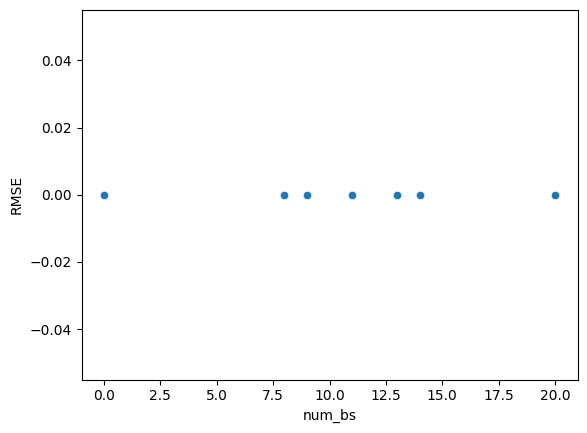

In [ ]:
sns.scatterplot(infom, x='num_bs', y='RMSE')